In [1]:
import io
import json
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zstandard as zstd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

os.makedirs("figures", exist_ok=True)

sns.set_theme(style="whitegrid", palette="colorblind")

In [2]:
def read_jsonl_zst_files(file_path):
    data = []
    with open(file_path, "rb") as f:
        dctx = zstd.ZstdDecompressor()
        with dctx.stream_reader(f) as reader:
            text_stream = io.TextIOWrapper(reader, encoding="utf-8")
            for line in text_stream:
                data.append(json.loads(line.strip()))
    return pd.DataFrame(data)

In [3]:
def plot_score_distribution(df, prefix):
    # Compute score and starting size
    df["delta"] = (df["closest"] - df["target"]).abs()
    df["score"] = (10 - df["delta"]).clip(0, 10)
    df["size"] = df["starting"].apply(len)

    plt.figure(figsize=(10, 6))
    g = sns.FacetGrid(df, col="size", col_wrap=3)
    bins = len(df["score"].unique())
    g.map(sns.histplot, "score", bins=bins, kde=False)
    g.set_axis_labels("Score", "Count")
    g.set_titles("{col_name} Numbers")
    g.figure.suptitle("Score Distribution for 3–8 Starting Numbers")
    plt.tight_layout()
    plt.savefig(f"figures/{prefix}_score_distribution.png")
    plt.close()

In [4]:
def remove_duplicates(df):
    original_len = len(df)
    df["starting"] = df["starting"].apply(tuple)
    df = df.drop_duplicates(subset=["starting", "target"]).reset_index(drop=True)
    df["starting"] = df["starting"].apply(list)
    print(f"Removed {original_len - len(df)} duplicates")
    return df

In [5]:
def stratified_split(df, test_size=0.2, random_state=42):
    # Ensure the required columns exist
    if "score" not in df.columns or "size" not in df.columns:
        df["delta"] = (df["closest"] - df["target"]).abs()
        df["score"] = (10 - df["delta"]).clip(0, 10)
        df["size"] = df["starting"].apply(len)

    # Create a combined stratification key: e.g., "10_5" means score 10 and size 5.
    stratify_key = df.apply(lambda row: f"{row['score']}_{row['size']}", axis=1)

    # Identify groups that are too small for stratification
    counts = stratify_key.value_counts()
    rare_keys = counts[counts < 2].index.tolist()

    if rare_keys:
        # Split the dataset into 'common' and 'rare' parts.
        common_mask = ~stratify_key.isin(rare_keys)
        df_common = df[common_mask]
        strat_key_common = stratify_key[common_mask]
        df_rare = df[~common_mask]

        # Stratified split on the common data
        train_common, test_common = train_test_split(
            df_common,
            test_size=test_size,
            random_state=random_state,
            stratify=strat_key_common,
        )

        # For the rare rows, assign randomly (maintaining the test_size proportion)
        df_rare = df_rare.sample(frac=1, random_state=random_state)  # shuffle
        n_rare = len(df_rare)
        n_test_rare = int(round(test_size * n_rare))
        test_rare = df_rare.iloc[:n_test_rare]
        train_rare = df_rare.iloc[n_test_rare:]

        # Combine the splits and reshuffle
        train_df = (
            pd.concat([train_common, train_rare])
            .sample(frac=1, random_state=random_state)
            .reset_index(drop=True)
        )
        test_df = (
            pd.concat([test_common, test_rare])
            .sample(frac=1, random_state=random_state)
            .reset_index(drop=True)
        )
    else:
        # All groups have at least 2 examples, so we can stratify directly.
        train_df, test_df = train_test_split(
            df, test_size=test_size, random_state=random_state, stratify=stratify_key
        )

    return train_df, test_df

In [6]:
def plot_train_test_distribution(train_df, test_df, prefix="train_test"):
    # Create copies and label them
    train_copy = train_df.copy()
    test_copy = test_df.copy()
    train_copy["split"] = "train"
    test_copy["split"] = "test"

    # Combine into one DataFrame for easy plotting.
    combined = pd.concat([train_copy, test_copy], ignore_index=True)

    # Ensure that the 'score' and 'size' columns exist.
    if "score" not in combined.columns or "size" not in combined.columns:
        combined["delta"] = (combined["closest"] - combined["target"]).abs()
        combined["score"] = (10 - combined["delta"]).clip(0, 10)
        combined["size"] = combined["starting"].apply(len)

    # Set up the plotting area: two subplots for score and starting size.
    _, axes = plt.subplots(1, 2, figsize=(10, 3))

    # Plot the Score distribution.
    sns.histplot(
        data=combined, x="score", hue="split", multiple="dodge", bins=11, ax=axes[0]
    )
    axes[0].set_title("Score Distribution by Split")
    axes[0].set_xlabel("Score")
    axes[0].set_ylabel("Count")

    size_min = combined["size"].min()
    size_max = combined["size"].max()
    bins = range(size_min, size_max + 2)

    sns.histplot(
        data=combined, x="size", hue="split", multiple="dodge", bins=bins, ax=axes[1]
    )
    axes[1].set_title("Starting Size Distribution by Split")
    axes[1].set_xlabel("Size")
    axes[1].set_ylabel("Count")

    plt.tight_layout()
    plt.savefig(f"figures/{prefix}_distribution_comparison.png")
    plt.show()

Removed 478 duplicates


<Figure size 1000x600 with 0 Axes>

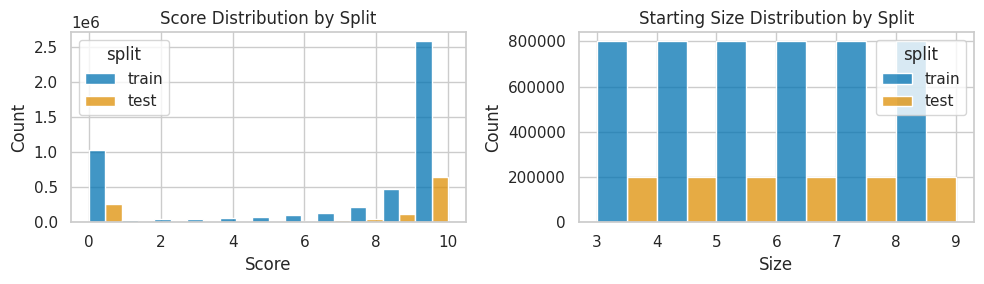

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2400 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2400 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1200 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/552 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/alexjackson17/countdown-numbers-3-8/commit/b22f86faf08ce5fc94d3777b21c2a0be17982708', commit_message='Upload dataset', commit_description='', oid='b22f86faf08ce5fc94d3777b21c2a0be17982708', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/alexjackson17/countdown-numbers-3-8', endpoint='https://huggingface.co', repo_type='dataset', repo_id='alexjackson17/countdown-numbers-3-8'), pr_revision=None, pr_num=None)

In [7]:
# Process the first dataset (random_3_8_1m)
df_random = read_jsonl_zst_files("data/random_3_8_1m.jsonl.zst")
plot_score_distribution(df_random, "random_3_8_1m")
df_random = remove_duplicates(df_random)
train_random, test_random = stratified_split(df_random, test_size=0.2)
plot_train_test_distribution(train_random, test_random, "random_3_8_1m")

# Save train and test splits as Hugging Face datasets
dataset_random_train = Dataset.from_pandas(train_random)
dataset_random_test = Dataset.from_pandas(test_random)
dataset_dict = DatasetDict({"train": dataset_random_train, "test": dataset_random_test})

dataset_dict.push_to_hub("alexjackson17/countdown-numbers-3-8", private=False)

In [8]:
del (
    df_random,
    train_random,
    test_random,
    dataset_random_train,
    dataset_random_test,
    dataset_dict,
)

Removed 2558 duplicates


<Figure size 1000x600 with 0 Axes>

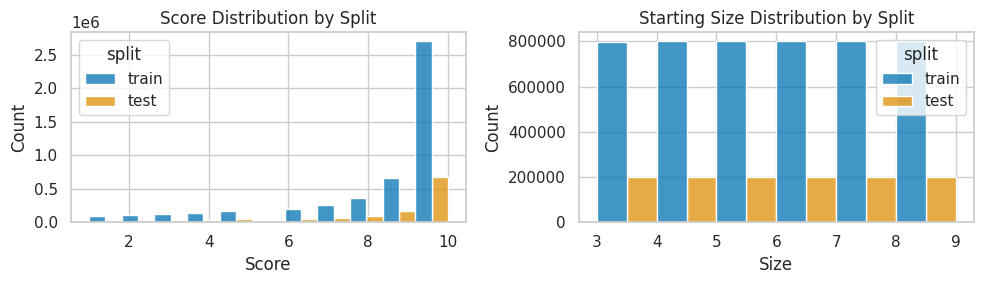

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2399 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2399 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1200 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/alexjackson17/countdown-numbers-3-8-nz/commit/f52ab8d7a31bc29f3a0924b7637f6112353fc311', commit_message='Upload dataset', commit_description='', oid='f52ab8d7a31bc29f3a0924b7637f6112353fc311', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/alexjackson17/countdown-numbers-3-8-nz', endpoint='https://huggingface.co', repo_type='dataset', repo_id='alexjackson17/countdown-numbers-3-8-nz'), pr_revision=None, pr_num=None)

In [9]:
# Process the second dataset (random_solvable_3_8_1m)
df_random_solvable = read_jsonl_zst_files("data/random_solvable_3_8_1m.jsonl.zst")
plot_score_distribution(df_random_solvable, "random_solvable_3_8_1m")
df_random_solvable = remove_duplicates(df_random_solvable)
train_random_solvable, test_random_solvable = stratified_split(
    df_random_solvable, test_size=0.2
)
plot_train_test_distribution(
    train_random_solvable, test_random_solvable, "random_solvable_3_8_1m"
)

dataset_random_solvable_train = Dataset.from_pandas(train_random_solvable)
dataset_random_solvable_test = Dataset.from_pandas(test_random_solvable)
dataset_dict = DatasetDict(
    {"train": dataset_random_solvable_train, "test": dataset_random_solvable_test}
)

dataset_dict.push_to_hub("alexjackson17/countdown-numbers-3-8-nz", private=False)

In [10]:
del (
    df_random_solvable,
    train_random_solvable,
    test_random_solvable,
    dataset_random_solvable_train,
    dataset_random_solvable_test,
    dataset_dict,
)

Removed 644 duplicates


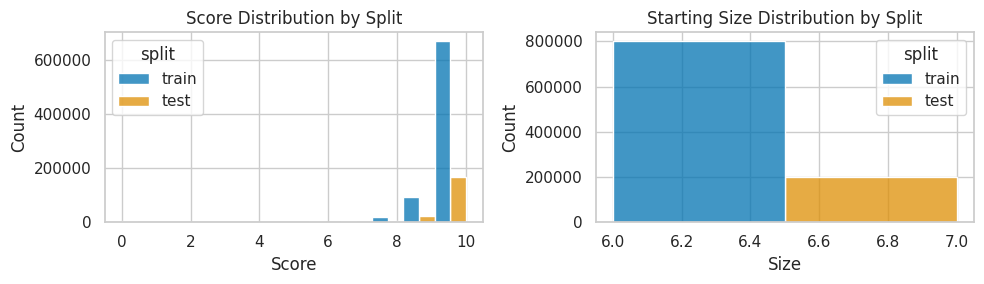

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/800 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/200 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/alexjackson17/countdown-numbers-6-gr/commit/454975fc2be77df3227fc0f58ac74bab93aa9a7b', commit_message='Upload dataset', commit_description='', oid='454975fc2be77df3227fc0f58ac74bab93aa9a7b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/alexjackson17/countdown-numbers-6-gr', endpoint='https://huggingface.co', repo_type='dataset', repo_id='alexjackson17/countdown-numbers-6-gr'), pr_revision=None, pr_num=None)

In [11]:
# Process the countdown_random_1m dataset
countdown_df = read_jsonl_zst_files("data/countdown_random_1m.jsonl.zst")
countdown_df["delta"] = (countdown_df["closest"] - countdown_df["target"]).abs()
countdown_df["score"] = (10 - countdown_df["delta"]).clip(0, 10)
countdown_df["size"] = countdown_df["starting"].apply(len)

plt.figure(figsize=(5, 3))
sns.histplot(countdown_df["score"], bins=11, kde=False)
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Score Distribution for Countdown Numbers")
plt.tight_layout()
plt.savefig("figures/countdown_score_distribution.png")
plt.close()

countdown_df = remove_duplicates(countdown_df)
train_countdown, test_countdown = stratified_split(countdown_df, test_size=0.2)
plot_train_test_distribution(train_countdown, test_countdown, "countdown_random_1m")

dataset_countdown_train = Dataset.from_pandas(train_countdown)
dataset_countdown_test = Dataset.from_pandas(test_countdown)
dataset_dict = DatasetDict(
    {"train": dataset_countdown_train, "test": dataset_countdown_test}
)

dataset_dict.push_to_hub("alexjackson17/countdown-numbers-6-gr", private=False)